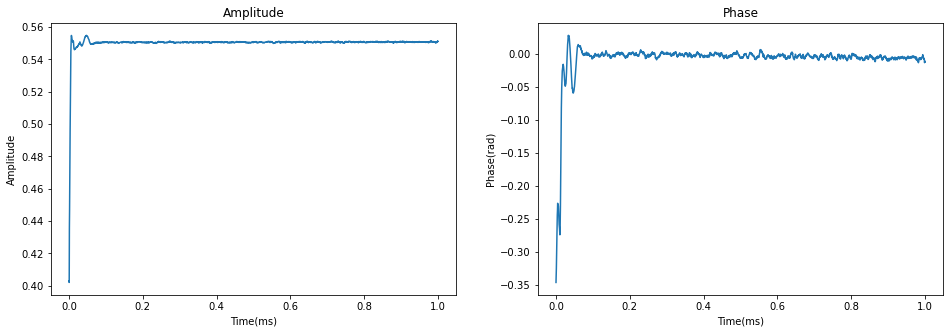

0db (dp, dv) =  (0.00010911652508218307, 5.751775987792409e-05)


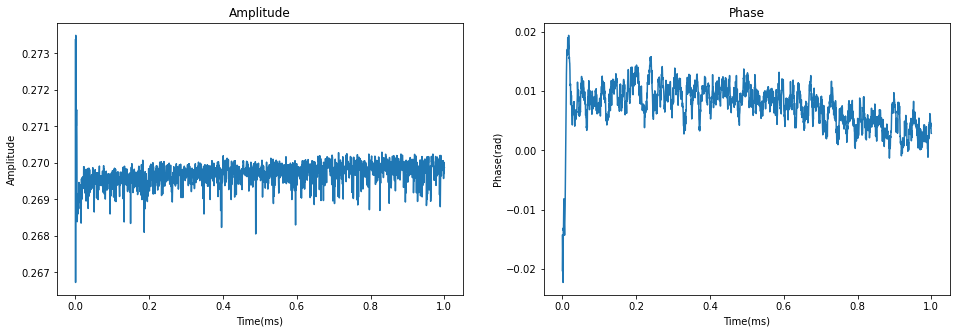

10db (dp, dv) =  (-0.000119771970041656, -6.313448313876658e-05)


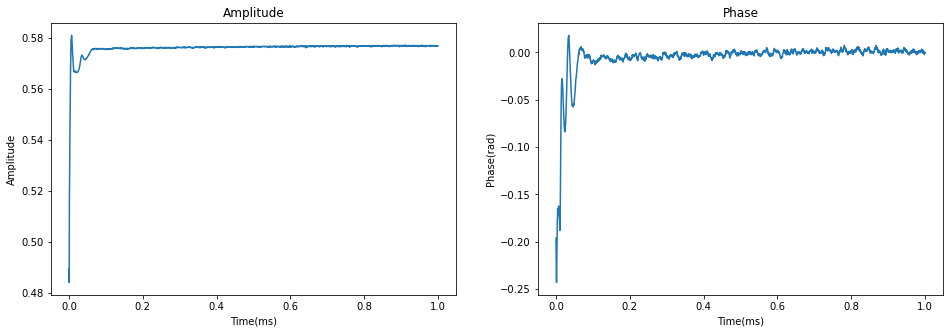

1db (dp, dv) =  (8.520543199122736e-05, 4.491368813179362e-05)


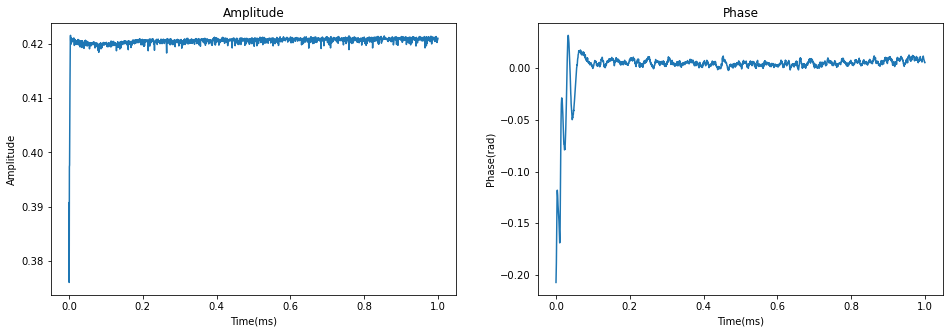

2db (dp, dv) =  (-2.7445234325544932e-05, -1.4466996603320268e-05)


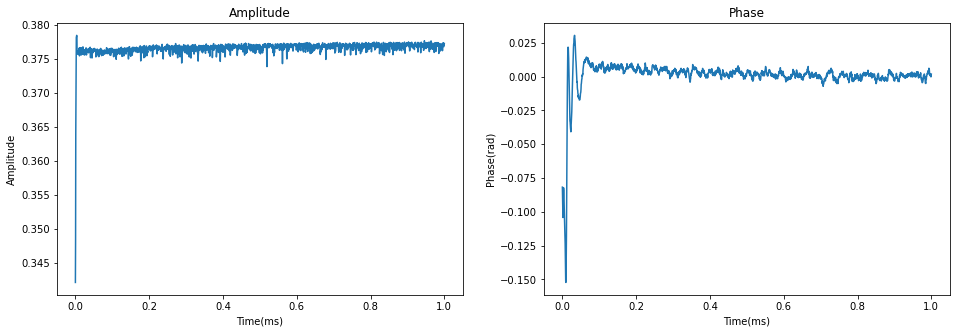

3db (dp, dv) =  (-1.274841726483435e-05, -6.719975755368453e-06)


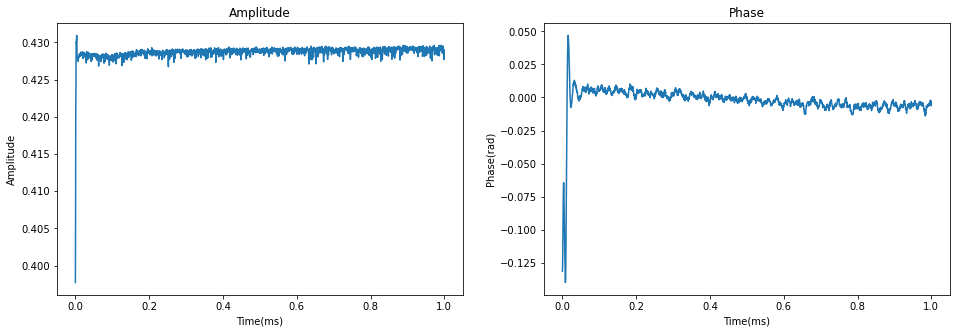

4db (dp, dv) =  (3.891240235592279e-05, 2.051159724244727e-05)


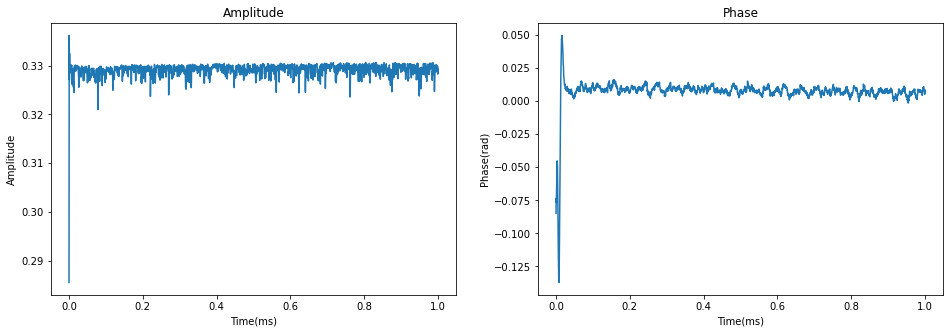

5db (dp, dv) =  (-0.00011346984439132736, -5.981249181249315e-05)


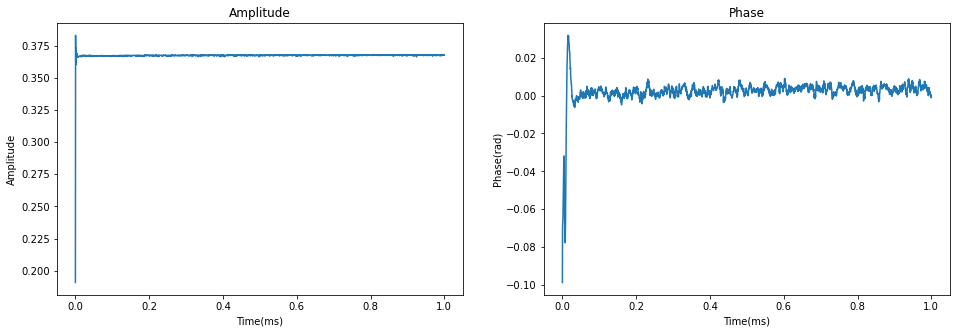

6db (dp, dv) =  (-3.509330851224422e-05, -1.849846749434984e-05)


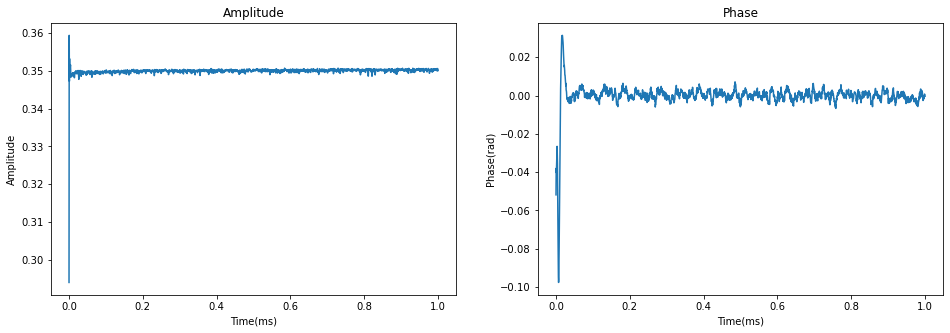

7db (dp, dv) =  (3.0540690565717596e-06, 1.6098680792317088e-06)


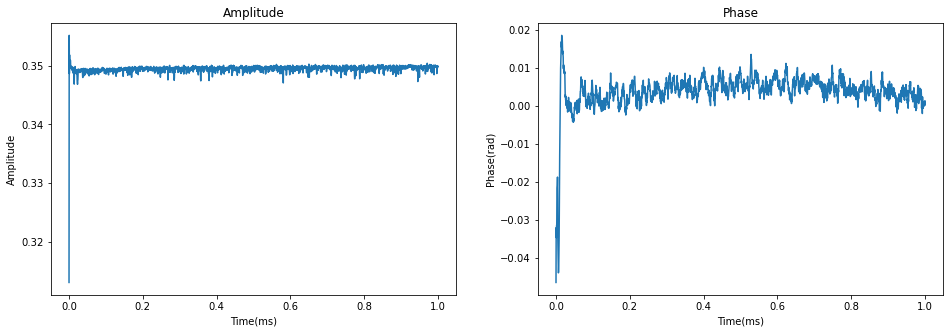

8db (dp, dv) =  (-6.055208547819752e-05, -3.191835801240326e-05)


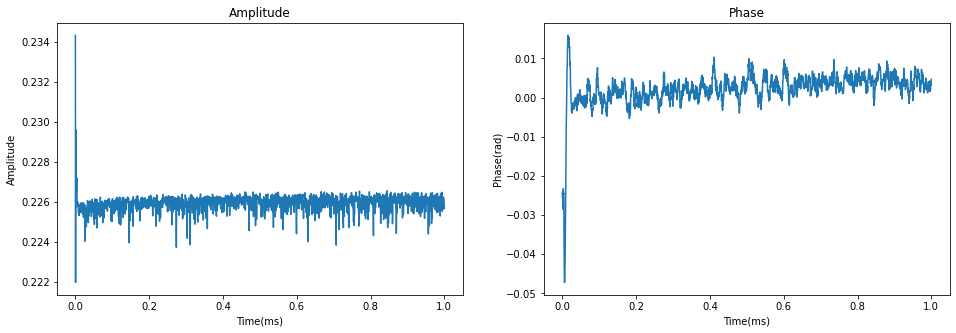

9db (dp, dv) =  (-3.561835493743416e-05, -1.8775231203477237e-05)


In [133]:
import pandas as pd
import csv
import glob, os
import matplotlib.pyplot as plt
from numpy import pi, sin, cos, sqrt, arctan
import numpy as np

filenames=glob.glob(r'C:\Users\c_che\OneDrive\Desktop\Year 4 Sem 1\FYP\single_shot_data_3\0\*.csv')

#Read csv file and translate timestamp into time(us)
"""input: full path of filename & threshold value, outputs: dataframe"""
def prep_f(fn):
    df = pd.read_csv(fn,header=None,names=['timestamp','amplitude','phase/rad'])
    frame_size, T = list(df.iloc[0])[:2]
    frame_size = int(frame_size.split(' ')[-1])
    T = float(T.split(' ')[-1])
    #immediately there is a problem: timestamp only has 0.1ms resolution - breaks when samples are 50us apart
    df = df.iloc[3:]
    df['t/us'] = np.linspace(0,T,frame_size)
    df = df.set_index('t/us').iloc[:-1]
    df = df.dropna(axis = 0, how = 'any') #drop nan row
    df = df.drop('timestamp',axis='columns') #redundant col
    df = df.applymap(lambda x: float(x)) #convert str to float
    #only consider values above certain threshold
    df = df[df['amplitude']>0.5*np.array(df['amplitude'])[-1]]
    return df

#Define Rabi sensitivity function
T = 1    #normalised units
d = 0.399343/T
pt = np.linspace(0, 1, 8000)
o = (pi/2) - arctan(2*T*d)
o3 = (pi*sqrt(1+(2*T*d)**2))*(pt/T)
o4 = (pi*sqrt(1+(2*T*d)**2))*((T-pt)/T)
g = (sin(o))**2 * cos(o) * ((1 - cos(o4))*sin(o3) + (1 - cos(o3))*sin(o4))
I = np.trapz(g, x=pt, axis = 0)

#Define differentiated Rabi sensitivity function
def sens(data):
    data['phase/rad']= np.unwrap(data['phase/rad'])
    data['phase/rad'] = data['phase/rad'] - np.mean(np.array(data['phase/rad'][-20:]))
    data = data.iloc[:2000]
    df = data['phase/rad']
    t = np.linspace(0, ((len(df)/2e6)/80e-3), len(data))
    o1 = (pi*sqrt(1+(2*T*d)**2))*(t/T)
    o2 = (pi*sqrt(1+(2*T*d)**2))*((T-t)/T)
    dg = ((2*pi*d)/(1+(2*T*d)**2)) * ((1 - cos(o2))*cos(o1) - (1 - cos(o1))*cos(o2))
    dp = -0.5*np.trapz(dg*df, x=t, axis = 0) #change in excitation probability
    dv = dp/(pi*I) #change in frequency
    #Plot graphs
    fig, [ax0,ax1] = plt.subplots(1,2,figsize=(16,5))
    ax0.title.set_text('Amplitude')
    ax1.title.set_text('Phase')
    ax0.set(xlabel="Time(ms)",ylabel="Amplitude")
    ax1.set(xlabel="Time(ms)",ylabel="Phase(rad)")
    ax0.plot(t*80,data['amplitude'])
    ax1.plot(t*80,data['phase/rad'])
    plt.show()
    return dp, dv

for i in filenames:
    sep = '_'
    print(os.path.basename(i).split(sep, 1)[0], "(dp, dv) = ", sens(prep_f(i)))

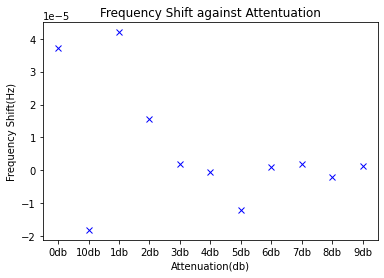

In [138]:
def freq(data):
    data['phase/rad']= np.unwrap(data['phase/rad'])
    data['phase/rad'] = data['phase/rad'] - np.mean(np.array(data['phase/rad'][-20000:]))
    data = data.iloc[:500]
    df = data['phase/rad']
    t = np.linspace(0, ((len(df)/2e6)/80e-3), len(data))
    o1 = (pi*sqrt(1+(2*T*d)**2))*(t/T)
    o2 = (pi*sqrt(1+(2*T*d)**2))*((T-t)/T)
    dg = ((2*pi*d)/(1+(2*T*d)**2)) * ((1 - cos(o2))*cos(o1) - (1 - cos(o1))*cos(o2))
    dp = -0.5*np.trapz(dg*df, x=t, axis = 0) #change in excitation probability
    dv = dp/(pi*I) #change in frequency
    return dv
attn = []
v = []
for i in filenames:
    sep = '_'
    attn.append(os.path.basename(i).split(sep, 1)[0])
    v.append(freq(prep_f(i)))
    
plt.plot(attn, v, "bx")
plt.title("Frequency Shift against Attentuation")
plt.xlabel("Attenuation(db)"); plt.ylabel("Frequency Shift(Hz)")
plt.show()